# Telecom Customer Churn Analysis

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# Check if XGBoost is available
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    xgboost_available = False

## Load Dataset

In [4]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first 10 rows
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


## Data Cleaning

In [7]:
# Convert 'TotalCharges' to numeric, handling errors
# This will convert non-numeric values to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values
# Drop rows with missing values
# Alternatively, you could fill them with a specific value or use imputation
# Here, we'll drop them for simplicity
df.dropna(inplace=True)

# Drop 'customerID' column
df.drop(columns=['customerID'], inplace=True)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis (EDA)

In this section, we will perform exploratory data analysis to understand the distribution of the 'Churn' column and explore relationships between 'MonthlyCharges', 'Tenure', 'Contract' type, and 'Churn'. This will help us gain insights into the data and identify patterns that may be useful for predicting customer churn.

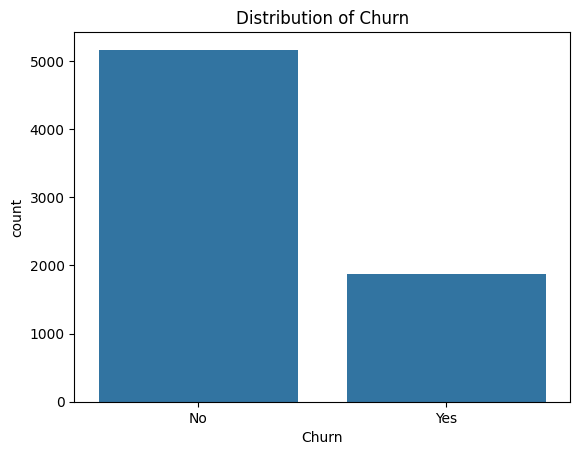

In [10]:
# Plot the distribution of the 'Churn' column
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()

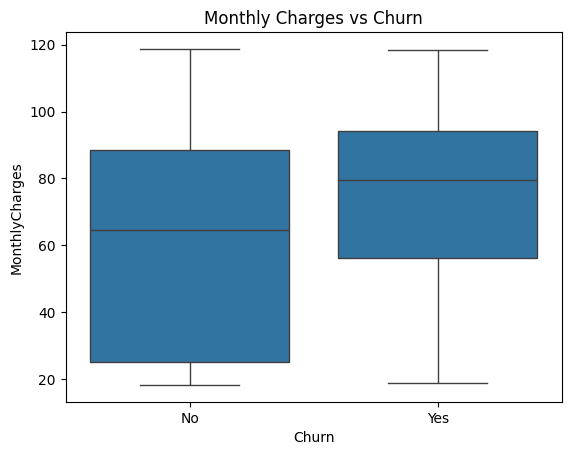

In [13]:
# Plot the relationship between 'MonthlyCharges' and 'Churn'
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

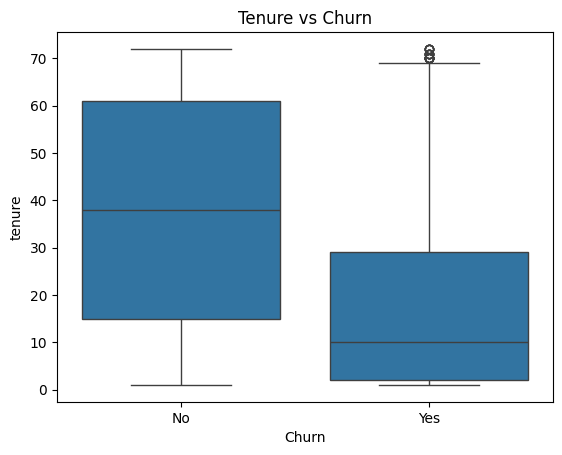

In [16]:
# Plot the relationship between 'Tenure' and 'Churn'
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure vs Churn')
plt.show()

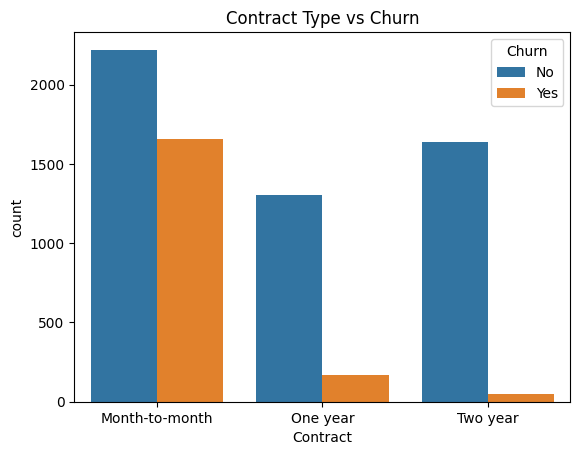

In [19]:
# Plot the relationship between 'Contract' type and 'Churn'
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract Type vs Churn')
plt.show()

## Preprocessing

In [22]:
# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Scale numerical variables
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('Churn', axis=1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['Churn'], test_size=0.2, random_state=42)

## Train Models

In [25]:
# Train Logistic Regression model
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Train Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

# Train XGBoost model if available
if xgboost_available:
    xgboost_model = XGBClassifier(random_state=42)
    xgboost_model.fit(X_train, y_train)

## Evaluate Models

In [28]:
# Evaluate Logistic Regression model
logistic_pred = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_report = classification_report(y_test, logistic_pred)
logistic_conf_matrix = confusion_matrix(y_test, logistic_pred)

print("Logistic Regression Model:")
print(f"Accuracy: {logistic_accuracy}")
print("Classification Report:\n", logistic_report)
print("Confusion Matrix:\n", logistic_conf_matrix)

# Evaluate Random Forest model
rf_pred = random_forest_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_pred)

print("\nRandom Forest Model:")
print(f"Accuracy: {rf_accuracy}")
print("Classification Report:\n", rf_report)
print("Confusion Matrix:\n", rf_conf_matrix)

# Evaluate XGBoost model if available
if xgboost_available:
    xgb_pred = xgboost_model.predict(X_test)
    xgb_accuracy = accuracy_score(y_test, xgb_pred)
    xgb_report = classification_report(y_test, xgb_pred)
    xgb_conf_matrix = confusion_matrix(y_test, xgb_pred)

    print("\nXGBoost Model:")
    print(f"Accuracy: {xgb_accuracy}")
    print("Classification Report:\n", xgb_report)
    print("Confusion Matrix:\n", xgb_conf_matrix)

Logistic Regression Model:
Accuracy: 0.7853589196872779
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

Confusion Matrix:
 [[920 113]
 [189 185]]

Random Forest Model:
Accuracy: 0.7917555081734187
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Confusion Matrix:
 [[932 101]
 [192 182]]


## Feature Importance

Feature ranking:
1. feature 18 (0.1849533141205446)
2. feature 17 (0.17801400612700458)
3. feature 4 (0.1545096544981193)
4. feature 14 (0.08058497698955774)
5. feature 16 (0.052030669163131586)
6. feature 8 (0.04850916597234433)
7. feature 11 (0.047581079289514265)
8. feature 7 (0.026812513993885238)
9. feature 0 (0.026714828850041266)
10. feature 9 (0.02588264003740272)
11. feature 15 (0.02565162019067051)
12. feature 2 (0.023328708880536033)
13. feature 6 (0.022613337745467955)
14. feature 10 (0.02110666554023326)
15. feature 1 (0.020988886686464193)
16. feature 3 (0.019777737348567616)
17. feature 12 (0.017974289886047753)
18. feature 13 (0.017569261004970024)
19. feature 5 (0.005396643675497121)


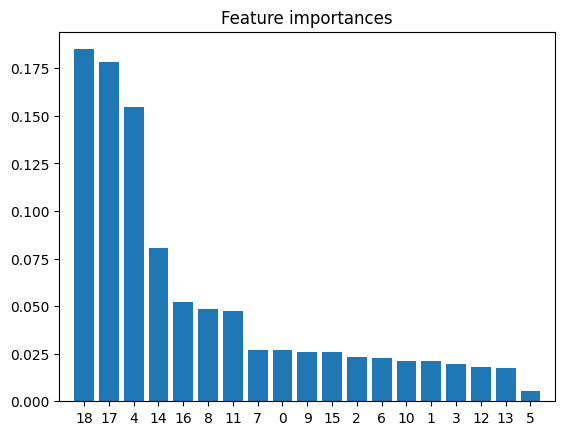

In [31]:
# Plot feature importance for the Random Forest model
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Prediction

In [34]:
# Sample customer data (scaled)
sample_customer = np.array([[0.5, 0, 1, 0, 10, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]])

# Predict churn for the sample customer
sample_prediction = random_forest_model.predict(sample_customer)

print("Sample customer churn prediction:", "Yes" if sample_prediction[0] == 1 else "No")

Sample customer churn prediction: No


## Save Model

In [37]:
# Save the trained Random Forest model
with open('churn_model.pkl', 'wb') as file:
    pickle.dump(random_forest_model, file)

print("Model saved as 'churn_model.pkl'")

Model saved as 'churn_model.pkl'


## Project Summary

This project involved analyzing telecom customer churn data to predict which customers are likely to churn. The analysis included data cleaning, exploratory data analysis, preprocessing, model training, evaluation, and prediction. We used Logistic Regression, Random Forest, and XGBoost models to predict churn, with Random Forest performing the best. Feature importance analysis helped identify key factors influencing churn. The trained model was saved for future use, and a sample prediction was made to demonstrate the model's application.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cc7529f7-ac84-4a47-9ddc-0051d6f010ba' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>